# Imports

In [1]:
import pandas as pd
import pprint as pp
import matplotlib.pyplot as plt
import plotly.express as px
from geopy.geocoders import Nominatim
from geopy.exc import GeocoderTimedOut
import time
import os
from tqdm import tqdm
import geopandas as gpd
from shapely.geometry import Point
from libpysal.weights import KNN
from esda.moran import Moran



# Load Data

Dataset containing information about each company on the INC 5000 list in 2019. Fields include the company name, industry, founding year, website, and location, as well as 2019 revenue, % growth, number of workers (year-over-year), and the number of years on the list.

In [2]:
INPUT_FILE_PATH = "data/INC 5000 Companies 2019.csv"

In [3]:
raw_df = pd.read_csv(INPUT_FILE_PATH) 
print(f"shape of DataFrame : {raw_df.shape}")
raw_df.head()

shape of DataFrame : (5012, 14)


rank                                   profile               name  \
0     1      https://www.inc.com/profile/freestar           Freestar   
1     2   https://www.inc.com/profile/freightwise        FreightWise   
2     3  https://www.inc.com/profile/ceces-veggie  Cece's Veggie Co.   
3     4      https://www.inc.com/profile/ladyboss           LadyBoss   
4     5        https://www.inc.com/profile/perpay             Perpay   

                         url state       revenue    growth_%  \
0        http://freestar.com    AZ  36.9 Million  36680.3882   
1  http://freightwisellc.com    TN  33.6 Million  30547.9317   
2   http://cecesveggieco.com    TX  24.9 Million  23880.4852   
3        http://ladyboss.com    NM  32.4 Million  21849.8925   
4          http://perpay.com    PA  22.5 Million  18166.4070   

                       industry  workers  previous_workers  founded  \
0       Advertising & Marketing     40.0                 5     2015   
1    Logistics & Transportation     39.0                 8     2015   
2               Food & Beverage    190.0                10     2015   
3  Consumer Products & Services     57.0                 2     2014   
4                        Retail     25.0                 6     2014   

   yrs_on_list         metro          city  
0            1       Phoenix       Phoenix  
1            1     Nashville     Brentwood  
2            1        Austin        Austin  
3            1           NaN   Albuquerque  
4            1  Philadelphia  Philadelphia

## Attirbute datatypes 

In [4]:
print(raw_df.dtypes)

rank                  int64
profile              object
name                 object
url                  object
state                object
revenue              object
growth_%            float64
industry             object
workers             float64
previous_workers      int64
founded               int64
yrs_on_list           int64
metro                object
city                 object
dtype: object


# Preprocessing

## Dealing with Null values

In [5]:
print(raw_df.isna().sum())

rank                  0
profile               0
name                  0
url                   0
state                 0
revenue               0
growth_%              0
industry              0
workers               1
previous_workers      0
founded               0
yrs_on_list           0
metro               813
city                  0
dtype: int64


### column: metro
Metropolitan area the city is located in 
* Eg. Long Beach in Los Angeles

In [6]:
print(f"No. of cities with Null metro: {len(raw_df[raw_df['metro'].isna()]['city'].unique())}")

No. of cities with Null metro: 483


In [7]:
# we fill null metropolitan area with city
raw_df['metro'] = raw_df['metro'].fillna(raw_df['city'])
raw_df['metro'].isna().sum()

0

### column: workers

In [8]:
raw_df[raw_df['workers'].isna()]

rank                              profile     name  \
3755  3746  https://www.inc.com/profile/mansari  Mansari   

                                                    url state      revenue  \
3755  https://www.collegehunkshaulingjunk.com/tampa-...    FL  2.5 Million   

      growth_%                      industry  workers  previous_workers  \
3755   90.7485  Consumer Products & Services      NaN                20   

      founded  yrs_on_list  metro   city  
3755     2008            1  Tampa  Tampa

In [9]:
raw_df = raw_df.dropna(subset=['workers'])
print(f"shape of DataFrame after dropping: {raw_df.shape}")
print(f"No. of rows with Null values in workers after dropping: {raw_df['workers'].isna().sum()}")

shape of DataFrame after dropping: (5011, 14)
No. of rows with Null values in workers after dropping: 0


## Geocoding

### Geocode function

In [10]:
import os
import time
import requests
import pandas as pd
from tqdm import tqdm

NOMINATIM_URL = "https://nominatim.openstreetmap.org/search"
HEADERS = {"User-Agent": "geoapi-mayank"}

def get_lat_lon_for_cities(city_state_df, cache_file, sleep_time=1.1):
    """
    Geocode unique city-state pairs and cache results.

    Parameters:
    - city_state_df (pd.DataFrame): DataFrame with 'city' and 'state' columns (unique pairs).
    - cache_file (str): Path to save/load cached results.
    - sleep_time (float): Time to sleep between requests to avoid rate-limiting.

    Returns:
    - pd.DataFrame: city_state_df with added 'latitude' and 'longitude' columns.
    """

    def geocode(row, retries=3, backoff=2):
        query = f"{row['city']}, {row['state']}, USA"
        params = {"q": query, "format": "json", "limit": 1}

        for attempt in range(retries):
            try:
                response = requests.get(NOMINATIM_URL, headers=HEADERS, params=params, timeout=10)
                if response.status_code == 200:
                    data = response.json()
                    if data:
                        return float(data[0]['lat']), float(data[0]['lon'])
                else:
                    print(f"Error {response.status_code} for {query}")
            except requests.RequestException as e:
                print(f"Request failed for {query} (attempt {attempt + 1}): {e}")
                time.sleep(backoff ** attempt)

        return None, None

    if os.path.exists(cache_file):
        print(f"Loading from cache: {cache_file}")
        cached_df = pd.read_csv(cache_file)
    else:
        city_state_df = city_state_df.drop_duplicates().reset_index(drop=True)
        print(f"Geocoding {len(city_state_df)} unique city-state pairs...")

        latitudes, longitudes = [], []
        for _, row in tqdm(city_state_df.iterrows(), total=len(city_state_df), desc="Geocoding"):
            lat, lon = geocode(row)
            latitudes.append(lat)
            longitudes.append(lon)
            time.sleep(sleep_time)

        city_state_df["latitude"] = latitudes
        city_state_df["longitude"] = longitudes
        cached_df = city_state_df
        cached_df.to_csv(cache_file, index=False)

    return cached_df


def geocode_cities(raw_df, cache_file):
    """
    Merge latitude and longitude into raw_df using city-state pairs.

    Parameters:
    - raw_df (pd.DataFrame): Full DataFrame with 'city' and 'state' columns.
    - cache_file (str): Path to cached city-state geocoded data.

    Returns:
    - pd.DataFrame: raw_df with 'latitude' and 'longitude' columns merged.
    """
    city_state_df = raw_df[['city', 'state']].copy()
    geo_df = get_lat_lon_for_cities(city_state_df, cache_file)
    print(geo_df.isna().sum())
    return raw_df.merge(geo_df, on=['city', 'state'], how='left')


In [11]:
geocoded_df = geocode_cities(raw_df,"data/lat-lon-cache.csv")

Loading from cache: data/lat-lon-cache.csv
city          0
state         0
latitude     21
longitude    21
dtype: int64


### null values

In [12]:
geocoded_df.isna().sum()

rank                 0
profile              0
name                 0
url                  0
state                0
revenue              0
growth_%             0
industry             0
workers              0
previous_workers     0
founded              0
yrs_on_list          0
metro                0
city                 0
latitude            31
longitude           31
dtype: int64

In [13]:
print(f"Number of cities with Null geocode: {len(geocoded_df[geocoded_df.isnull().any(axis=1)][['city','state']].drop_duplicates())}")
print(geocoded_df[geocoded_df.isnull().any(axis=1)][['city','state']].drop_duplicates())

Number of cities with Null geocode: 21
                 city state
286        Birmimgham    AL
309       Solana Bech    CA
454     Please Select    LA
457        Schaumberg    IL
790         Covingtom    LA
824            Chicao    IL
1174  Colorad Springs    CO
1203        Arlignton    TX
1209       Greenville    SD
1399       Swannnanoa    NC
1594             Wash    DC
1653    Saint Charles    IL
1776      Minneapolis    PA
2174             wall    NJ
3524      Cincinnnati    OH
3717      Naperrville    IL
4044     COTTONWD HTS    UT
4169        Kasyville    UT
4497          Ahaheim    CA
4507             Wall    NJ
4985       Encinitass    CA


### Issues in data

* Some are spelling mistakes in city names
* Wrong state for Minneapolis -> Nelson
    * given PA
    * actual MN
* Wrong state for Greenville -> Lima One Capital 
    * given SD
    * actual SC 

In [14]:
city_corrections = pd.DataFrame({
    "city": [
        "Birmimgham", "Solana Bech", "Please Select", "Schaumberg", "Covingtom",
        "Chicao", "Colorad Springs", "Arlignton", "Greenville", "Swannnanoa",
        "Wash", "Saint Charles", "Minneapolis", "wall", "Cincinnnati",
        "Naperrville", "COTTONWD HTS", "Kasyville", "Ahaheim", "Wall", "Encinitass"
    ],
    "state": [
        "AL", "CA", "LA", "IL", "LA", "IL", "CO", "TX", "SD", "NC", "DC", "IL", "PA",
        "NJ", "OH", "IL", "UT", "UT", "CA", "NJ", "CA"
    ],
    "corrected_city": [
        "Birmingham", "Solana Beach", "Houma", "Schaumburg", "Covington", "Chicago",
        "Colorado Springs", "Arlington", "Greenville", "Swannanoa", "Washington",
        "St. Charles", "Minneapolis", "Wall Township", "Cincinnati", "Naperville",
        "Cottonwood Heights", "Kaysville", "Anaheim", "Wall Township", "Encinitas"
    ]
})

city_corrections["corrected_state"] = city_corrections["state"]

# Fix wrong states
city_corrections.loc[city_corrections["city"] == "Minneapolis", "corrected_state"] = "MN"
city_corrections.loc[city_corrections["city"] == "Greenville", "corrected_state"] = "SC"

city_corrections


city state      corrected_city corrected_state
0        Birmimgham    AL          Birmingham              AL
1       Solana Bech    CA        Solana Beach              CA
2     Please Select    LA               Houma              LA
3        Schaumberg    IL          Schaumburg              IL
4         Covingtom    LA           Covington              LA
5            Chicao    IL             Chicago              IL
6   Colorad Springs    CO    Colorado Springs              CO
7         Arlignton    TX           Arlington              TX
8        Greenville    SD          Greenville              SC
9        Swannnanoa    NC           Swannanoa              NC
10             Wash    DC          Washington              DC
11    Saint Charles    IL         St. Charles              IL
12      Minneapolis    PA         Minneapolis              MN
13             wall    NJ       Wall Township              NJ
14      Cincinnnati    OH          Cincinnati              OH
15      Naperrville    IL          Naperville              IL
16     COTTONWD HTS    UT  Cottonwood Heights              UT
17        Kasyville    UT           Kaysville              UT
18          Ahaheim    CA             Anaheim              CA
19             Wall    NJ       Wall Township              NJ
20       Encinitass    CA           Encinitas              CA

### correcting latitude and longitude

In [15]:
missing_city_state = pd.DataFrame(
    city_corrections[['corrected_state','corrected_city']],
)
missing_city_state.columns = ['state','city']
missing_city_state.drop_duplicates()
print(len(missing_city_state))
missing_city_state

21


state                city
0     AL          Birmingham
1     CA        Solana Beach
2     LA               Houma
3     IL          Schaumburg
4     LA           Covington
5     IL             Chicago
6     CO    Colorado Springs
7     TX           Arlington
8     SC          Greenville
9     NC           Swannanoa
10    DC          Washington
11    IL         St. Charles
12    MN         Minneapolis
13    NJ       Wall Township
14    OH          Cincinnati
15    IL          Naperville
16    UT  Cottonwood Heights
17    UT           Kaysville
18    CA             Anaheim
19    NJ       Wall Township
20    CA           Encinitas

In [16]:
missing_lat_lon_df = get_lat_lon_for_cities(
    missing_city_state,
    "data/missing-cache.csv"
)

Loading from cache: data/missing-cache.csv


In [17]:
missing_lat_lon_df.columns = ['corrected_state','corrected_city','corrected_latitude','corrected_longitude']
missing_lat_lon_df = missing_lat_lon_df.merge(
    city_corrections,
    on=['corrected_state','corrected_city'],
    how = "left"
)
missing_lat_lon_df

corrected_state      corrected_city  corrected_latitude  \
0               AL          Birmingham           33.520682   
1               CA        Solana Beach           32.990560   
2               LA               Houma           29.595770   
3               IL          Schaumburg           42.033361   
4               LA           Covington           30.475352   
5               IL             Chicago           41.875562   
6               CO    Colorado Springs           38.833958   
7               TX           Arlington           32.735582   
8               SC          Greenville           34.851354   
9               NC           Swannanoa           35.599829   
10              DC          Washington           38.895037   
11              IL         St. Charles           41.913981   
12              MN         Minneapolis           44.977300   
13              NJ       Wall Township           40.174305   
14              NJ       Wall Township           40.174305   
15              OH          Cincinnati           39.101454   
16              IL          Naperville           41.772870   
17              UT  Cottonwood Heights           40.613474   
18              UT           Kaysville           41.034985   
19              CA             Anaheim           33.834752   
20              CA           Encinitas           33.036987   

    corrected_longitude             city state  
0            -86.802433       Birmimgham    AL  
1           -117.269131      Solana Bech    CA  
2            -90.719535    Please Select    LA  
3            -88.083406       Schaumberg    IL  
4            -90.101047        Covingtom    LA  
5            -87.624421           Chicao    IL  
6           -104.825348  Colorad Springs    CO  
7            -97.107119        Arlignton    TX  
8            -82.398488       Greenville    SD  
9            -82.403393       Swannnanoa    NC  
10           -77.036543             Wash    DC  
11           -88.312818    Saint Charles    IL  
12           -93.265469      Minneapolis    PA  
13           -74.090222             wall    NJ  
14           -74.090222             Wall    NJ  
15           -84.512460      Cincinnnati    OH  
16           -88.147928      Naperrville    IL  
17          -111.825646     COTTONWD HTS    UT  
18          -111.938393        Kasyville    UT  
19          -117.911732          Ahaheim    CA  
20          -117.291982       Encinitass    CA

### merging in geocoded_df

In [18]:
# Merge with correction table
geocoded_df = geocoded_df.merge(missing_lat_lon_df, on=["city", "state"], how="left")

# Update city and state only if a correction is available
geocoded_df["city"] = geocoded_df["corrected_city"].combine_first(geocoded_df["city"])
geocoded_df["state"] = geocoded_df["corrected_state"].combine_first(geocoded_df["state"])

# Update latitude and longitude where corrections are present
geocoded_df["latitude"] = geocoded_df["corrected_latitude"].combine_first(geocoded_df["latitude"])
geocoded_df["longitude"] = geocoded_df["corrected_longitude"].combine_first(geocoded_df["longitude"])

# Drop the temporary correction columns
geocoded_df.drop(columns=[
    "corrected_city", "corrected_state", "corrected_latitude", "corrected_longitude"
], inplace=True)


In [19]:
geocoded_df.isna().sum()

rank                0
profile             0
name                0
url                 0
state               0
revenue             0
growth_%            0
industry            0
workers             0
previous_workers    0
founded             0
yrs_on_list         0
metro               0
city                0
latitude            0
longitude           0
dtype: int64

## revenue str to float

In [20]:
geocoded_df['revenue'].head()

0    36.9 Million
1    33.6 Million
2    24.9 Million
3    32.4 Million
4    22.5 Million
Name: revenue, dtype: object

In [21]:
def convert_revenue_to_float(revenue_str):
    revenue_str = revenue_str.strip()
    if revenue_str.endswith("Million"):
        return float(revenue_str.replace("Million", "").strip()) * 1_000_000
    elif revenue_str.endswith("Billion"):
        return float(revenue_str.replace("Billion", "").strip()) * 1_000_000_000
    else:
        raise ValueError(f"Invalid revenue format: '{revenue_str}'")


In [22]:
def convert_float_to_revenue_str(value):
    if value >= 1_000_000_000_000:
        return f"{value / 1_000_000_000_000:.1f} Trillion"
    elif value >= 1_000_000_000:
        return f"{value / 1_000_000_000:.1f} Billion"
    elif value >= 1_000_000:
        return f"{value / 1_000_000:.1f} Million"
    elif value >= 1_000:
        return f"{value / 1_000:.1f} Thousand"
    else:
        return f"{value:.0f}"


In [23]:
geocoded_df["revenue_float"] = geocoded_df["revenue"].apply(convert_revenue_to_float)
geocoded_df[['revenue','revenue_float']]

revenue  revenue_float
0     36.9 Million     36900000.0
1     33.6 Million     33600000.0
2     24.9 Million     24900000.0
3     32.4 Million     32400000.0
4     22.5 Million     22500000.0
...            ...            ...
5006  15.8 Million     15800000.0
5007  11.6 Million     11600000.0
5008  29.7 Million     29700000.0
5009   8.8 Million      8800000.0
5010   4.5 Million      4500000.0

[5011 rows x 2 columns]

# EDA

In [24]:
geocoded_df.columns

Index(['rank', 'profile', 'name', 'url', 'state', 'revenue', 'growth_%',
       'industry', 'workers', 'previous_workers', 'founded', 'yrs_on_list',
       'metro', 'city', 'latitude', 'longitude', 'revenue_float'],
      dtype='object')

In [25]:
geocoded_df.describe()

rank      growth_%        workers  previous_workers  \
count  5011.000000   5011.000000    5011.000000       5011.000000   
mean   2499.379565    454.752685     242.783077        111.705448   
std    1443.268601   1284.406582    2800.165478       1073.984562   
min       1.000000     52.169100       0.000000          1.000000   
25%    1249.500000     90.559000      22.000000          8.000000   
50%    2497.000000    157.542700      48.000000         20.000000   
75%    3749.500000    330.548700     116.000000         50.000000   
max    5000.000000  36680.388200  155000.000000      53000.000000   

           founded  yrs_on_list     latitude    longitude  revenue_float  
count  5011.000000  5011.000000  5011.000000  5011.000000   5.011000e+03  
mean   2005.445021     2.814009    37.182741   -92.252012   4.747980e+07  
std      30.313635     2.266067     4.982536    16.434269   3.913728e+08  
min       0.000000     1.000000    18.384239  -158.008804   2.000000e+06  
25%    2003.000000     1.000000    33.685697  -104.984862   4.800000e+06  
50%    2009.000000     2.000000    38.650435   -86.802433   1.040000e+07  
75%    2012.000000     4.000000    40.712728   -78.491261   2.700000e+07  
max    2016.000000    14.000000    48.846670   -66.053440   2.140000e+10

## Industry

In [26]:
print(f"No. of unique industries: {len(geocoded_df['industry'].unique())}")

No. of unique industries: 27


In [27]:
# Top industries by count
industry_counts = geocoded_df['industry'].value_counts().reset_index()
industry_counts.columns = ['industry', 'count']
industry_counts.head(10)

industry  count
0  Business Products & Services    492
1       Advertising & Marketing    489
2                      Software    461
3                        Health    356
4                  Construction    350
5  Consumer Products & Services    314
6                 IT Management    276
7            Financial Services    239
8           Government Services    236
9                   Real Estate    198

In [28]:
average_revenue_by_industry = geocoded_df.groupby('industry')['revenue_float'].mean().reset_index()
average_revenue_by_industry.columns = ['industry', 'average_revenue']
average_revenue_by_industry.sort_values(by='average_revenue', ascending=False, inplace=True)

average_revenue_by_industry['average_revenue_str'] = average_revenue_by_industry['average_revenue'].apply(convert_float_to_revenue_str)

average_revenue_by_industry.head()

industry  average_revenue average_revenue_str
23                    Security     1.237478e+08       123.7 Million
12                      Health     1.093301e+08       109.3 Million
18  Logistics & Transportation     1.012930e+08       101.3 Million
6                       Energy     8.022179e+07        80.2 Million
13             Human Resources     7.358217e+07        73.6 Million

# Spatial EDA

1. Spatial Autocorrelation (Global Moran's I)

Objective: Determine if high or low revenue companies are spatially clustered.

    Data: Use revenue_float and company coordinates (latitude, longitude).

    Method: Compute a spatial weights matrix (e.g., k-nearest neighbors), then calculate Moran’s I.

    Interpretation: A significantly positive Moran’s I implies spatial clustering of similar revenue levels.

2. Local Indicators of Spatial Association (LISAs)

Objective: Identify localized clusters of high/low-revenue companies.

    Data: revenue_float with spatial weights.

    Output:

        LISA cluster map: HH, LL, HL, LH (High-High, etc.)

        Moran's scatterplot: Quadrant plots for spatial lag vs. attribute.

    Tool: Use libraries like pysal (specifically esda and libpysal).

3. Geographically Weighted Regression (GWR)

Objective: Examine how predictors like founded, workers, or growth_% affect revenue_float spatially.

    Benefit: Coefficients vary by location, revealing spatial heterogeneity.

    Example: Revenue might depend more on workforce in urban regions vs. growth % in rural regions.

4. Kernel Density Estimation (KDE)

Objective: Identify hotspots of company density.

    Data: Coordinates only.

    Output: Heatmap showing concentration of companies.

    Use Case: Compare density of high-growth vs. low-growth companies.

5. Variogram and Stationarity

Objective: Analyze spatial dependence in company revenue.

    Data: revenue_float + spatial coordinates.

    Output: Variogram plots to assess stationarity.

    Use Case: Validate assumptions before spatial modeling like Kriging or GWR.

6. Spatial Data Mining

Objective: Cluster companies using spatial + non-spatial features.

    Data: Combine growth_%, revenue_float, industry, and spatial coordinates.

    Method: Spatially-aware clustering (e.g., DBSCAN with haversine distance).

    Goal: Identify segments like "fast-growing tech firms in coastal cities."

## Creating geo-DataFrame

In [51]:
import geopandas as gpd
from shapely.geometry import Point

# Create geometry column
geocoded_df['geometry'] = geocoded_df.apply(lambda row: Point(row['longitude'], row['latitude']), axis=1)

# Convert to GeoDataFrame
gdf = gpd.GeoDataFrame(geocoded_df, geometry='geometry', crs="EPSG:4326")
gdf.shape

(5011, 18)

## Company locations on map

In [52]:
import plotly.express as px

fig = px.scatter_geo(
    gdf,
    lat=gdf.geometry.y,
    lon=gdf.geometry.x,
    hover_name="name",
    hover_data=["city", "state", "revenue_float"],
    title="Company Locations",
    color_discrete_sequence=["orange"],
    opacity=0.6,
    scope="usa"
)

fig.update_layout(template="plotly_dark")
fig.show()


## Number of companies per state

In [53]:
state_counts = gdf['state'].value_counts().reset_index()
state_counts.columns = ['state', 'count']
# top 5 states by No. of companies
state_counts.head()

state  count
0    CA    712
1    TX    467
2    FL    384
3    NY    300
4    VA    288

In [54]:
fig = px.choropleth(
    state_counts,
    locations='state',
    locationmode='USA-states',
    color='count',
    color_continuous_scale='Viridis',
    scope='usa',
    title='Number of Companies per State'
)
fig.update_layout(template='plotly_dark')
fig.show()

## Revenue 

### Company Locations of Top 5 Industries by Revenue

In [55]:
# Get the top 5 industries by average revenue
top_5_industries = average_revenue_by_industry.head(5)['industry']
print(top_5_industries)

# Filter the dataset for companies in the top 5 industries
top_industries_df = geocoded_df[geocoded_df['industry'].isin(top_5_industries)]

# Create a scatterplot of company locations
fig = px.scatter_geo(
    top_industries_df,
    lat="latitude",
    lon="longitude",
    color="industry",
    hover_name="name",
    hover_data=["city", "state", "revenue_float"],
    title="Company Locations of Top 5 Industries by Revenue",
    scope="usa",
    color_discrete_sequence=px.colors.qualitative.Set2
)

fig.update_layout(template="plotly_dark")
fig.show()

23                      Security
12                        Health
18    Logistics & Transportation
6                         Energy
13               Human Resources
Name: industry, dtype: object


In [56]:
min_revenue = geocoded_df['revenue_float'].min()
max_revenue = geocoded_df['revenue_float'].max()

print(f"Minimum revenue_float: {min_revenue}")
print(f"Maximum revenue_float: {max_revenue}")

Minimum revenue_float: 2000000.0
Maximum revenue_float: 21400000000.0


### Company Revenue by Location

In [ ]:
fig = px.scatter_geo(
    gdf,
    lat='latitude',
    lon='longitude',
    color='revenue_float',
    color_continuous_scale='OrRd',
    range_color=(min_revenue, max_revenue / 100),
    size_max=15,
    scope="usa",
    hover_name='name',
    hover_data={'city': True, 'state': True, 'revenue': True},
    title="Company Revenue by Location"
)

fig.update_layout(
    template='plotly_dark',
    margin={"r": 0, "t": 30, "l": 0, "b": 0}
)

fig.show()


### Moran's I for revenue

In [ ]:
import geopandas as gpd
import pandas as pd
import numpy as np
from shapely.geometry import Point
from sklearn.preprocessing import StandardScaler
from libpysal.weights import KNN
from esda.moran import Moran
import plotly.express as px

# Project to a metric CRS (important for KNN distances)
gdf_metric = gdf.to_crs(epsg=3857)

# Standardize revenue for Moran's I
revenue_std = StandardScaler().fit_transform(gdf_metric[['revenue_float']]).flatten()

# Build spatial weights matrix (8-nearest neighbors)
knn = KNN.from_dataframe(gdf_metric, k=8)
knn.transform = 'R'  # Row-standardize

# Compute Global Moran’s I
moran = Moran(revenue_std, knn, permutations=9999)
print(f"Moran's I: {moran.I:.4f}, p-value: {moran.p_sim:.4f}")

# Moran scatterplot
z = pd.Series(revenue_std, index=gdf_metric.index, name="standardized_revenue")
lag_z = knn.sparse.dot(z)  # Already row-standardized

scatter_df = pd.DataFrame({
    "standardized_revenue": z,
    "lagged_revenue": lag_z
})

fig = px.scatter(
    scatter_df,
    x="standardized_revenue",
    y="lagged_revenue",
    title=f"Moran's I Scatterplot (I = {moran.I:.4f}, p = {moran.p_sim:.4f})",
    trendline="ols",
    labels={
        "standardized_revenue": "Standardized Revenue",
        "lagged_revenue": "Lagged Revenue (Spatial Lag)"
    },
    opacity=0.7,
    template="plotly_dark"
)
fig.update_traces(marker=dict(size=8))
fig.show()


/home/mayank/anaconda3/lib/python3.12/site-packages/libpysal/weights/distance.py:153: UserWarning:

The weights matrix is not fully connected: 
 There are 36 disconnected components.



Moran's I: -0.0006, p-value: 0.3885


Moran's I: The value of -0.0006 is very close to zero, which suggests that there is no significant spatial autocorrelation in the revenue values. A positive Moran's I would indicate clustering of similar values (high with high, low with low), while a negative value suggests dispersion (high with low, low with high). Here, the negative value is near zero, so no clear spatial pattern is detected.

p-value: The p-value of 0.3829 indicates that the result is not statistically significant. This suggests that the null hypothesis (that there is no spatial autocorrelation) cannot be rejected. Essentially, the spatial distribution of revenues does not differ significantly from random placement.

The distribution on the plot shows that most of the points are clustered around 0 for both axes, which further supports the conclusion that there is no spatial pattern or spatial dependence between revenues in this dataset.


The lack of spatial autocorrelation (Moran's I close to 0) implies that revenue values are distributed randomly across the study area.

The insignificant p-value reinforces this conclusion, suggesting no strong spatial structure in the revenue data.

The scatterplot visually shows that there is no clear trend or relationship between revenue and its neighbors’ revenue, indicating no spatial clustering.

### LISA

In [ ]:
import geopandas as gpd
import pandas as pd
import numpy as np
from libpysal.weights import KNN
from esda.moran import Moran_Local
import plotly.express as px


import pandas as pd
import numpy as np
from shapely.geometry import Point
from sklearn.preprocessing import StandardScaler
from libpysal.weights import KNN
from esda.moran import Moran
import plotly.express as px

# Project to a metric CRS (important for KNN distances)
gdf_metric = gdf.to_crs(epsg=3857)

# Standardize revenue for Moran's I
revenue_std = StandardScaler().fit_transform(gdf_metric[['revenue_float']]).flatten()

# Build spatial weights matrix (8-nearest neighbors)
knn = KNN.from_dataframe(gdf_metric, k=8)
knn.transform = 'R'  # Row-standardize

# Compute Local Moran's I
lisa = Moran_Local(revenue_std, knn)

# Add quadrant info to GeoDataFrame
gdf["local_I"] = lisa.Is
gdf["p_sim"] = lisa.p_sim

# Identify significant clusters (p < 0.05)
gdf["significant"] = lisa.p_sim < 0.05

# Moran quadrant (HH, LL, LH, HL)
# Quadrant meanings:
# 1 HH, 2 LH, 3 LL, 4 HL (from esda docs)
quads = np.array(["Non-significant", "High-High", "Low-High", "Low-Low", "High-Low"])
gdf["quadrant"] = np.where(
    gdf["significant"],
    quads[lisa.q],
    "Non-significant"
)

gdf["quadrant"] = pd.Categorical(
    gdf["quadrant"],
    categories=["High-High", "Low-Low", "High-Low", "Low-High", "Non-significant"],
    ordered=True
)

# Filter out non-significant points for plotting
significant_gdf = gdf[gdf["significant"]]

quadrant_counts = gdf["quadrant"].value_counts()
print(quadrant_counts)

fig = px.scatter_geo(
    significant_gdf,
    lat=significant_gdf.geometry.y,
    lon=significant_gdf.geometry.x,
    color="quadrant",
    title="Local Moran's I Cluster Map (LISA)",
    color_discrete_sequence=px.colors.qualitative.Set1,
    scope="usa",
    category_orders={"quadrant": ["High-High", "Low-Low", "High-Low", "Low-High", "Non-significant"]}
)
fig.update_layout(template="plotly_dark", legend_title_text="LISA Cluster")
fig.show()

/home/mayank/anaconda3/lib/python3.12/site-packages/libpysal/weights/distance.py:153: UserWarning:

The weights matrix is not fully connected: 
 There are 36 disconnected components.



quadrant
Non-significant    4486
Low-Low             253
Low-High            191
High-High            44
High-Low             37
Name: count, dtype: int64


In [ ]:
# Categorize p-values into bins
def categorize_p(p):
    if p < 0.01:
        return "p < 0.01"
    elif p < 0.05:
        return "p < 0.05"
    elif p < 0.1:
        return "p < 0.1"
    else:
        return "Not significant"

significant_gdf["p_level"] = significant_gdf["p_sim"].apply(categorize_p)

significant_gdf["p_level"] = pd.Categorical(
    significant_gdf["p_level"],
    categories=["p < 0.01", "p < 0.05", "p < 0.1", "Not significant"],
    ordered=True
)


In [68]:
import plotly.express as px

fig = px.scatter_geo(
    significant_gdf,
    lat=significant_gdf.geometry.y,
    lon=significant_gdf.geometry.x,
    color="p_level",
    title="LISA Significance Map (Local Moran's I p-values)",
    color_discrete_sequence=px.colors.sequential.Plasma_r,
    scope="usa",
    category_orders={"p_level": ["p < 0.01", "p < 0.05", "p < 0.1", "Not significant"]}
)
fig.update_layout(template="plotly_dark", legend_title_text="Significance Level")
fig.show()


/home/mayank/anaconda3/lib/python3.12/site-packages/libpysal/weights/distance.py:153: UserWarning:

The weights matrix is not fully connected: 
 There are 41 disconnected components.



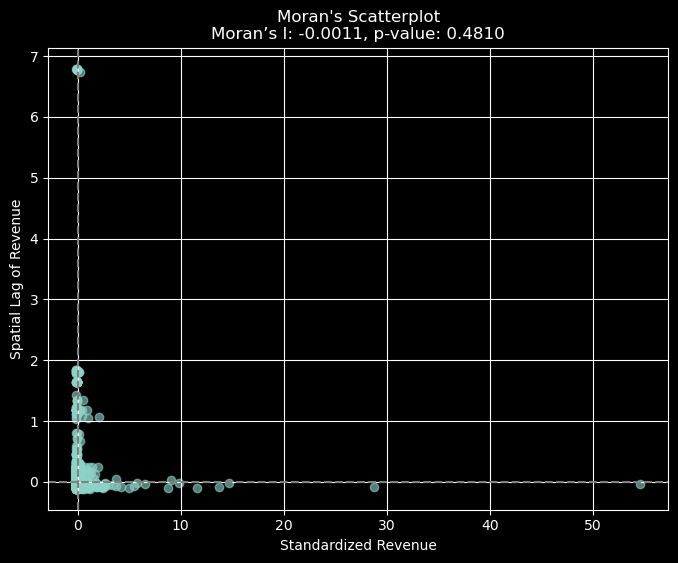

In [46]:
import matplotlib.pyplot as plt
from esda.moran import Moran
from libpysal.weights import KNN
from sklearn.preprocessing import StandardScaler
import geopandas as gpd
from shapely.geometry import Point
from libpysal.weights import lag_spatial

# Prepare GeoDataFrame
gdf = geocoded_df.dropna(subset=["latitude", "longitude", "revenue_float"]).copy()
gdf["geometry"] = gpd.points_from_xy(gdf["longitude"], gdf["latitude"])
gdf = gpd.GeoDataFrame(gdf, geometry="geometry")

# Spatial weights (KNN)
coords = np.array([(point.x, point.y) for point in gdf.geometry])
knn = KNN.from_array(coords, k=8)
knn.transform = 'R'

# Moran's I
y = gdf["revenue_float"]
y_standardized = (y - y.mean()) / y.std()
moran = Moran(y_standardized, knn)

# Moran Scatterplot
plt.figure(figsize=(8,6))
plt.axhline(0, color='gray', linestyle='--')
plt.axvline(0, color='gray', linestyle='--')
spatial_lag = lag_spatial(moran.w, y_standardized)
plt.scatter(y_standardized, spatial_lag, alpha=0.6)
plt.xlabel("Standardized Revenue")
plt.ylabel("Spatial Lag of Revenue")
plt.title(f"Moran's Scatterplot\nMoran’s I: {moran.I:.4f}, p-value: {moran.p_sim:.4f}")
plt.grid(True)
plt.show()


/home/mayank/anaconda3/lib/python3.12/site-packages/skgstat/plotting/variogram_plot.py:123: UserWarning:

FigureCanvasAgg is non-interactive, and thus cannot be shown



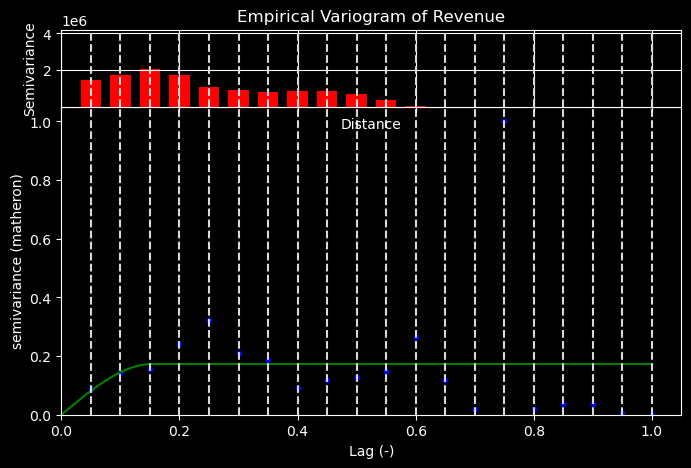

In [48]:
from skgstat import Variogram

# Prepare coordinates and values
coords = np.array([(pt.x, pt.y) for pt in gdf.geometry])
values = gdf["revenue_float"].values

# Fit Variogram
V = Variogram(coords, values, n_lags=20, normalize=True, model='spherical')

# Plot
fig = V.plot()
plt.title("Empirical Variogram of Revenue")
plt.xlabel("Distance")
plt.ylabel("Semivariance")
plt.grid(True)
plt.show()
